In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
import pandas as pd
import numpy as np

df = pd.read_csv('parkinsons_updrs.data')

# 定义目标变量和特征
random_state = 42
y = df['total_UPDRS']
X = df.loc[:, ~df.columns.isin(['total_UPDRS', 'test_time', 'Jitter(%)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA'])]
groups = df['subject#']

# Split into test and other sets
gss = GroupShuffleSplit(n_splits=1, test_size=0.8, random_state=random_state)
test_idx, other_idx = next(gss.split(X, y, groups))

X_test, y_test, groups_test = X.iloc[test_idx], y.iloc[test_idx], groups.iloc[test_idx]
X_other, y_other, groups_other = X.iloc[other_idx], y.iloc[other_idx], groups.iloc[other_idx]

# Preprocessing pipeline
onehot_ftrs = ['sex']
std_ftrs = ['subject#', 'age', 'motor_UPDRS', 'Jitter(Abs)', 'Shimmer(dB)', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)
    ]
)

# 定义 GroupKFold
group_kfold = GroupKFold(n_splits=4)

# 用于存储结果
test_scores = []
best_models = []

# 循环 GroupKFold
for train_idx, val_idx in group_kfold.split(X_other, y_other, groups_other):
    # Train and validation split
    X_train, X_val = X_other.iloc[train_idx], X_other.iloc[val_idx]
    y_train, y_val = y_other.iloc[train_idx], y_other.iloc[val_idx]

    # 数据预处理
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('model', LinearRegression())])

    # 训练模型
    clf.fit(X_train, y_train)

    # 验证集评估
    y_val_pred = clf.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    print(f"Validation RMSE: {val_rmse:.4f}")

    # 测试集评估
    y_test_pred = clf.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # 保存结果
    test_scores.append(test_rmse)
    best_models.append(clf)

# 计算平均 RMSE
mean_rmse = np.mean(test_scores)

# 打印结果
print("\nFinal Results:")
print(f"Test RMSE Scores: {test_scores}")
print(f"Average Test RMSE: {mean_rmse:.4f}")
print(np.std(test_scores))

    # 输出表现最佳的模型
best_model_index = np.argmin(test_scores)
global_best_model = best_models[best_model_index]
print("\nBest Model Across All Random States:")
print(global_best_model)



Validation RMSE: 4.9010
Validation RMSE: 3.6983
Validation RMSE: 2.9236
Validation RMSE: 3.3386

Final Results:
Test RMSE Scores: [3.863787367784428, 3.4985094954011724, 4.431067780683301, 4.866270230442944]
Average Test RMSE: 4.1649
0.5238107027401879

Best Model Across All Random States:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex']),
                                                 ('std', StandardScaler(),
                                                  ['subject#', 'age',
                                                   'motor_UPDRS', 'Jitter(Abs)',
                                                   'Shimmer(dB)', 'NHR', 'HNR',
                                                   'RPDE', 'DFA', 'PPE'])])

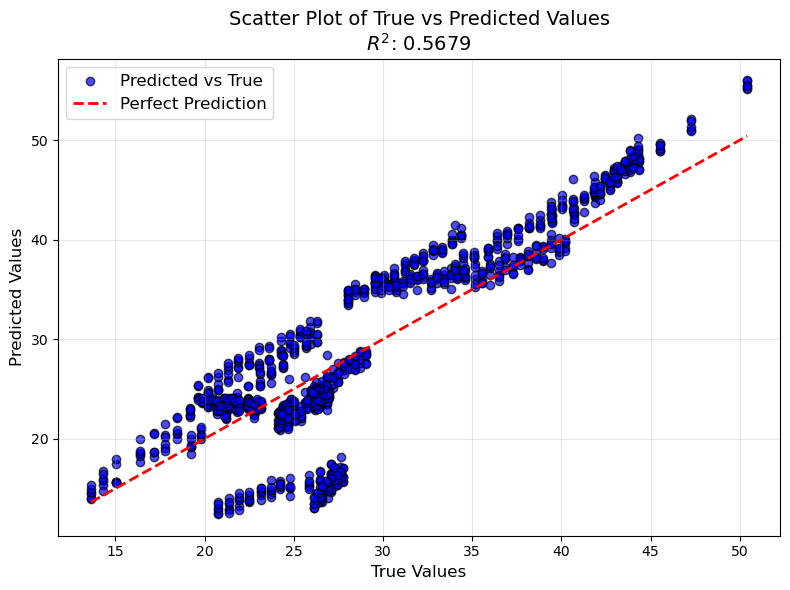

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Calculate R^2 score
r2 = r2_score(y_test, y_test_pred)

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, color='blue', edgecolor='k', label='Predicted vs True')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.title(f"Scatter Plot of True vs Predicted Values\n$R^2$: {r2:.4f}", fontsize=14)
plt.xlabel("True Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [62]:
import pandas as pd
correlation = pd.DataFrame(X).corrwith(pd.Series(y_test))
print(correlation.sort_values(ascending=False))

motor_UPDRS    0.927768
subject#       0.678061
age            0.426433
Shimmer(dB)    0.314391
RPDE           0.310398
PPE            0.226326
Jitter(Abs)    0.203059
NHR            0.159914
DFA           -0.082357
sex           -0.255210
HNR           -0.293769
dtype: float64


In [83]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

# 加载数据
df = pd.read_csv('parkinsons_updrs.data')

# 目标变量和特征
target_column = 'total_UPDRS'
y = df[target_column]
X = df.loc[:, ~df.columns.isin([target_column])]

# 添加交互特征（选择 Pearson 相关性较高的特征）
high_corr_features = ['age', 'motor_UPDRS', 'subject#']  # 根据 Pearson 结果选择
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interaction_features = poly.fit_transform(X[high_corr_features])
interaction_feature_names = poly.get_feature_names_out(high_corr_features)

# 将交互特征加入 X
interaction_df = pd.DataFrame(interaction_features, columns=interaction_feature_names)
X = pd.concat([X, interaction_df], axis=1)

# 打印新生成的特征
print("New features generated:")
print(X.head())


New features generated:
   subject#  age  sex  test_time  motor_UPDRS  Jitter(%)  Jitter(Abs)  \
0         1   72    0     5.6431       28.199    0.00662     0.000034   
1         1   72    0    12.6660       28.447    0.00300     0.000017   
2         1   72    0    19.6810       28.695    0.00481     0.000025   
3         1   72    0    25.6470       28.905    0.00528     0.000027   
4         1   72    0    33.6420       29.187    0.00335     0.000020   

   Jitter:RAP  Jitter:PPQ5  Jitter:DDP  ...     HNR     RPDE      DFA  \
0     0.00401      0.00317     0.01204  ...  21.640  0.41888  0.54842   
1     0.00132      0.00150     0.00395  ...  27.183  0.43493  0.56477   
2     0.00205      0.00208     0.00616  ...  23.047  0.46222  0.54405   
3     0.00191      0.00264     0.00573  ...  24.445  0.48730  0.57794   
4     0.00093      0.00130     0.00278  ...  26.126  0.47188  0.56122   

       PPE   age  motor_UPDRS  subject#  age motor_UPDRS  age subject#  \
0  0.16006  72.0       2

In [84]:
# 检查是否有重复的列名
duplicated_columns = X.columns[X.columns.duplicated()]
print("Duplicated columns:", duplicated_columns)


Duplicated columns: Index(['age', 'motor_UPDRS', 'subject#'], dtype='object')


In [85]:
X = X.loc[:, ~X.columns.duplicated()]

Validation RMSE: 4.9196
Validation RMSE: 3.7935
Validation RMSE: 5.6479
Validation RMSE: 3.6807

Final Results:
Test RMSE Scores: [3.9718570165828972, 3.6431601218189766, 4.715960718187615, 5.2633737607858695]
Average Test RMSE: 4.3986


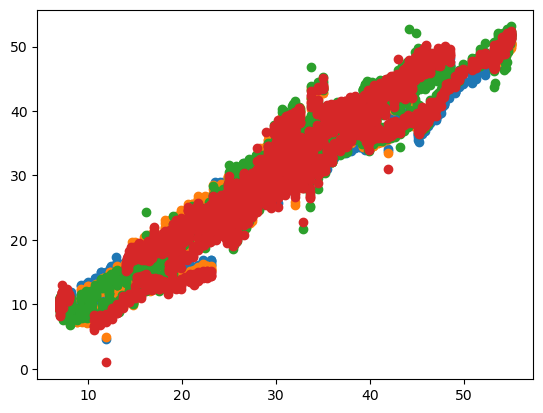

In [86]:
# Split into test and other sets
gss = GroupShuffleSplit(n_splits=1, test_size=0.8, random_state=random_state)
test_idx, other_idx = next(gss.split(X, y, groups))

X_test, y_test, groups_test = X.iloc[test_idx], y.iloc[test_idx], groups.iloc[test_idx]
X_other, y_other, groups_other = X.iloc[other_idx], y.iloc[other_idx], groups.iloc[other_idx]

# 定义 GroupKFold
group_kfold = GroupKFold(n_splits=4)

# Preprocessing pipeline
onehot_ftrs = ['sex']
std_ftrs = [col for col in X.columns if col != 'sex']

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)
    ]
)


# 用于存储结果
test_scores = []
best_models = []

# 循环 GroupKFold
for train_idx, val_idx in group_kfold.split(X_other, y_other, groups_other):
    # Train and validation split
    X_train, X_val = X_other.iloc[train_idx], X_other.iloc[val_idx]
    y_train, y_val = y_other.iloc[train_idx], y_other.iloc[val_idx]


    # 初始化线性回归模型
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('model', LinearRegression())])
    # 训练模型
    clf.fit(X_train, y_train)

    # 验证集评估
    y_val_pred = clf.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    print(f"Validation RMSE: {val_rmse:.4f}")

    y_train_pred = clf.predict(X_train)
    plt.scatter(y_train, y_train_pred)
    # 测试集评估
    y_test_pred = clf.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # 保存结果
    test_scores.append(test_rmse)
    best_models.append(clf)

# 计算平均 RMSE
mean_rmse = np.mean(test_scores)

# 打印最终结果
print("\nFinal Results:")
print(f"Test RMSE Scores: {test_scores}")
print(f"Average Test RMSE: {mean_rmse:.4f}")

# 输出表现最佳的模型


In [75]:
print("Training set mean:", X_other.mean())
print("Test set mean:", X_test.mean())

Training set mean: subject#                     21.665191
age                          64.544803
sex                           0.332912
test_time                    91.414298
motor_UPDRS                  21.377775
Jitter(%)                     0.006232
Jitter(Abs)                   0.000045
Jitter:RAP                    0.003005
Jitter:PPQ5                   0.003352
Jitter:DDP                    0.009016
Shimmer                       0.034760
Shimmer(dB)                   0.316833
Shimmer:APQ3                  0.017498
Shimmer:APQ5                  0.020690
Shimmer:APQ11                 0.028115
Shimmer:DDA                   0.052495
NHR                           0.033137
HNR                          21.328946
RPDE                          0.549755
DFA                           0.655919
PPE                           0.225471
age Shimmer(dB)              20.653097
age motor_UPDRS            1398.071683
Shimmer(dB) motor_UPDRS       6.940352
dtype: float64
Test set mean: subject#       

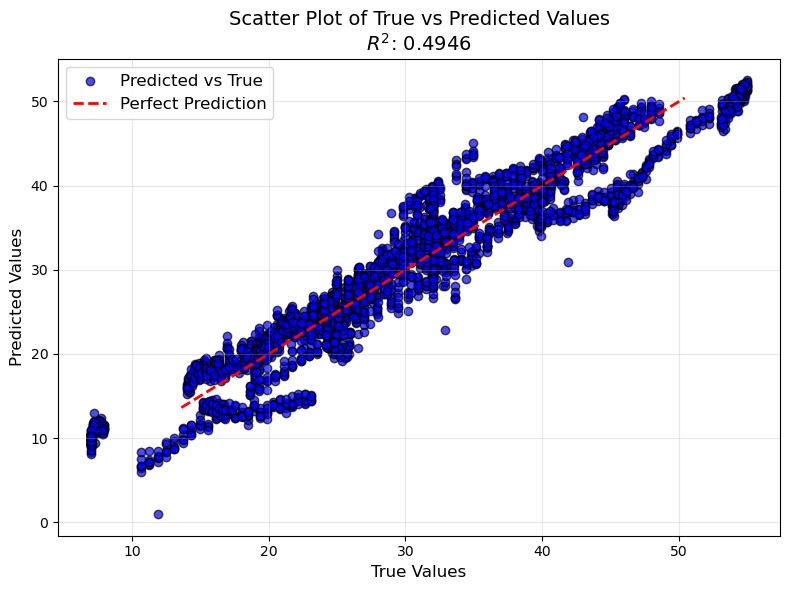

In [88]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Calculate R^2 score
r2 = r2_score(y_test, y_test_pred)

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, alpha=0.7, color='blue', edgecolor='k', label='Predicted vs True')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.title(f"Scatter Plot of True vs Predicted Values\n$R^2$: {r2:.4f}", fontsize=14)
plt.xlabel("True Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
